# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 4
# Regularization, High Dimensionality, PCA


**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook even if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A): 209A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

/Users/gwungwun/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

sns.set_context('poster')

# Continuing Bike Sharing Usage Data

In this homework, we will focus on multiple linear regression, regularization, dealing with high dimensionality, and PCA. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See Homework 3 for more information about the data.

*Note: please make sure you use all the processed data from HW 3 Part (a)...you make want to save the data set on your computer and reread the csv/json file here.


In [3]:
# Load data

data_train = pd.read_csv('data/Bikeshare_train.csv')
data_test = pd.read_csv('data/Bikeshare_test.csv')
data_train = data_train.drop('Unnamed: 0', 1)
data_test = data_test.drop('Unnamed: 0', 1)

data_train = pd.get_dummies(data_train, columns=['season', 'month', 'day_of_week', 'weather'])
data_train = data_train.drop(['season_4.0', 'month_12.0', 'day_of_week_6.0', 'weather_3.0'], 1)
data_test = pd.get_dummies(data_test, columns=['season', 'month', 'day_of_week', 'weather'])
data_test = data_test.drop(['season_4.0', 'month_12.0', 'day_of_week_6.0', 'weather_3.0'], 1)

cp = ['temp', 'atemp', 'humidity', 'windspeed']
cp_means = [data_train[v].mean() for v in cp]
cp_std = [data_train[v].std() for v in cp]
for i, v in enumerate(cp):
    data_train[v] = (data_train[v] - cp_means[i]) / cp_std[i]
    data_test[v] = (data_test[v] - cp_means[i]) / cp_std[i]

col_names = list(data_train.columns[7:]) + list(data_train.columns[:7])
all_predictors = col_names[:-1]
data_train = data_train[col_names]
data_test = data_test[col_names]

## Part (f): Regularization/Penalization Methods

As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

Use the following regularization techniques to fit linear models to the training set:
- Ridge regression
- Lasso regression
    
You may choose the shrikage parameter $\lambda$ from the set $\{10^{-5}, 10^{-4},...,10^{4},10^{5}\}$ using cross-validation. In each case, 

- How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrikage penalty) in Part (b) fropm HW 3? Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
- List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3?
- Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

We next analyze the performance of the two shrinkage methods for different training sample sizes:
- Generate random samples of sizes 100, 150, ..., 400 from the training set. You may use the following code to draw a random sample of a specified size from the training set:

In [4]:
#--------  sample
# A function to select a random sample of size k from the training set
# Input: 
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data)
#      k (size of sample) 
# Return: 
#      chosen sample of predictors and responses

def sample(x, y, k):
    n = x.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k)
    
    # Get predictors and reponses with the indices
    x_subset = x[subset_ind, :]
    y_subset = y[subset_ind]
    
    return (x_subset, y_subset)

- Fit linear, Ridge and Lasso regression models to each of the generated sample. In each case, compute the $R^2$ score for the model on the training sample on which it was fitted, and on the test set.
- Repeat the above experiment for 10 random trials/splits, and compute the average train and test $R^2$ across the trials for each training sample size. Also, compute the standard deviation (SD) in each case.
- Make a plot of the mean training $R^2$ scores for the linear, Ridge and Lasso regression methods as a function of the training sample size. Also, show a confidence interval for the mean scores extending from **mean - SD** to **mean + SD**. Make a similar plot for the test $R^2$ scores.

How do the training and test $R^2$ scores compare for the three methods? Give an explanation for your observations. How do the confidence intervals for the estimated $R^2$ change with training sample size? Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values. You may use the `plt.errorbar` function to plot confidence bars for the average $R^2$ scores.

In [5]:
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Fitting

X_train = data_train.iloc[:, :-1].values
y_train = data_train.iloc[:, -1].values

X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

linear_regression = LinearRegression(fit_intercept=True)
linear_regression.fit(X_train, y_train)
print('The test R^2 for the plain linear regression is {}.'.format(linear_regression.score(X_test, y_test)))

alphas = np.array([10**i for i in range(-5, 6)])
ridge_regression = RidgeCV(alphas=alphas, fit_intercept=True)
ridge_regression.fit(X_train, y_train)
print('The test R^2 for the Ridge regression is {}.'.format(ridge_regression.score(X_test, y_test)))

lasso_regression = LassoCV(alphas=alphas, fit_intercept=True)
lasso_regression.fit(X_train, y_train)
print('The test R^2 for the Lasso regression is {}.'.format(lasso_regression.score(X_test, y_test)))

The test R^2 for the plain linear regression is 0.24934211146527574.
The test R^2 for the Ridge regression is 0.25825181588390766.
The test R^2 for the Lasso regression is 0.26377723427905897.


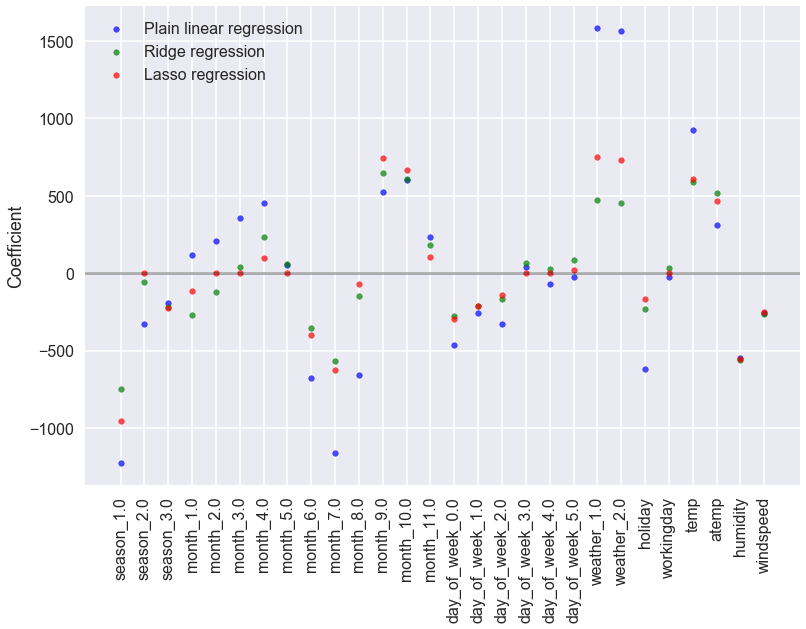

In [7]:
plt.scatter(range(len(all_predictors)), linear_regression.coef_, marker='.',\
           color='b', alpha=0.7, label='Plain linear regression');
plt.scatter(range(len(all_predictors)), ridge_regression.coef_, marker='.',\
           color='g', alpha=0.7, label='Ridge regression');
plt.scatter(range(len(all_predictors)), lasso_regression.coef_, marker='.',\
           color='r', alpha=0.7, label='Lasso regression');
plt.axhline(y=0, alpha=0.3, color='k');
plt.xticks(range(len(all_predictors)), all_predictors, rotation=90);
plt.ylabel('Coefficient');
plt.legend();

As we can see, the absolute value of most estimated coefficients is smaller for Ridge regression and Lasso regression than the plain linear regression. There are slight differences for the estimated coefficients obtained from Ridge regression and Lasso regression; some coefficients from Lasso regression reaches zero, while there is no zero coefficients from Ridge regression.

In [8]:
print('There is {} coefficient close to 0 by Ridge regression.'.\
     format(sum(np.abs(ridge_regression.coef_) < 1e-10)))
print()
print('There are {} coefficients close to 0 by Lasso regression:'.\
     format(sum(np.abs(lasso_regression.coef_) < 1e-10)))
print(', '.join(['{}'.format(all_predictors[i])\
                for i, v in enumerate(np.abs(lasso_regression.coef_) < 1e-10) if v]) + '.')

There is 0 coefficient close to 0 by Ridge regression.

There are 7 coefficients close to 0 by Lasso regression:
season_2.0, month_2.0, month_3.0, month_5.0, day_of_week_3.0, day_of_week_4.0, workingday.


These predictors all belong to the redundant predictors identified in Part (c) from HW 3; but there remains some redundant predictors having non-zero coefficients, such as temp/atemp.

In [9]:
print('The coefficients to temp and atemp by Ridge regression are {}, {}.'.\
     format(ridge_regression.coef_[all_predictors.index('temp')], \
            ridge_regression.coef_[all_predictors.index('atemp')]))
print('The coefficients to temp and atemp by Lasso regression are {}, {}.'.\
     format(lasso_regression.coef_[all_predictors.index('temp')], \
            lasso_regression.coef_[all_predictors.index('atemp')]))

The coefficients to temp and atemp by Ridge regression are 587.295654147897, 516.9296493186753.
The coefficients to temp and atemp by Lasso regression are 609.2251362451419, 468.4101220582492.


The way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp` is very similar.

In [10]:
# Sample size

def train_regression(k, alphas = np.array([10**i for i in range(-5, 6)])):
    X_subset, y_subset = sample(X_train, y_train, k)
    linear_regression = LinearRegression(fit_intercept=True)
    linear_regression.fit(X_subset, y_subset)
    ridge_regression = RidgeCV(alphas=alphas, fit_intercept=True)
    ridge_regression.fit(X_subset, y_subset)
    lasso_regression = LassoCV(alphas=alphas, fit_intercept=True)
    lasso_regression.fit(X_subset, y_subset)
    r2 = [linear_regression.score(X_subset, y_subset), linear_regression.score(X_test, y_test), \
          ridge_regression.score(X_subset, y_subset), ridge_regression.score(X_test, y_test), \
         lasso_regression.score(X_subset, y_subset), lasso_regression.score(X_test, y_test)]
    return r2    

In [11]:
k_list = np.arange(100, 401, 50, dtype=int)
for k in k_list:
    result = train_regression(k)
    print('k = {}:'.format(k))
    print('Linear regression: training R^2 {}; test R^2 {}.'.format(result[0], result[1]))
    print('Ridge regression: training R^2 {}; test R^2 {}.'.format(result[2], result[3]))
    print('Lasso regression: training R^2 {}; test R^2 {}.'.format(result[4], result[5]))
    print()

k = 100:
Linear regression: training R^2 0.7265320921932339; test R^2 -0.007664809888253687.
Ridge regression: training R^2 0.6556214293464319; test R^2 0.23669117450474697.
Lasso regression: training R^2 0.7020510225180168; test R^2 0.19209500908004418.

k = 150:
Linear regression: training R^2 0.6795357008954792; test R^2 0.13099409120129413.
Ridge regression: training R^2 0.6700497469205478; test R^2 0.16756072770615738.
Lasso regression: training R^2 0.6567587326501005; test R^2 0.18204645995018387.

k = 200:
Linear regression: training R^2 0.5485120397546149; test R^2 0.17050375559609654.
Ridge regression: training R^2 0.5124590194487944; test R^2 0.22095283621328143.
Lasso regression: training R^2 0.42380010065978047; test R^2 0.2250711322303723.

k = 250:
Linear regression: training R^2 0.6083098485552; test R^2 0.26846825943373387.
Ridge regression: training R^2 0.5798682903801516; test R^2 0.2680518240562366.
Lasso regression: training R^2 0.5984640977565876; test R^2 0.278875

In [12]:
# Repeat for 10 random trials/splits

results = [np.array([train_regression(k) for _ in range(10)]) for k in k_list]

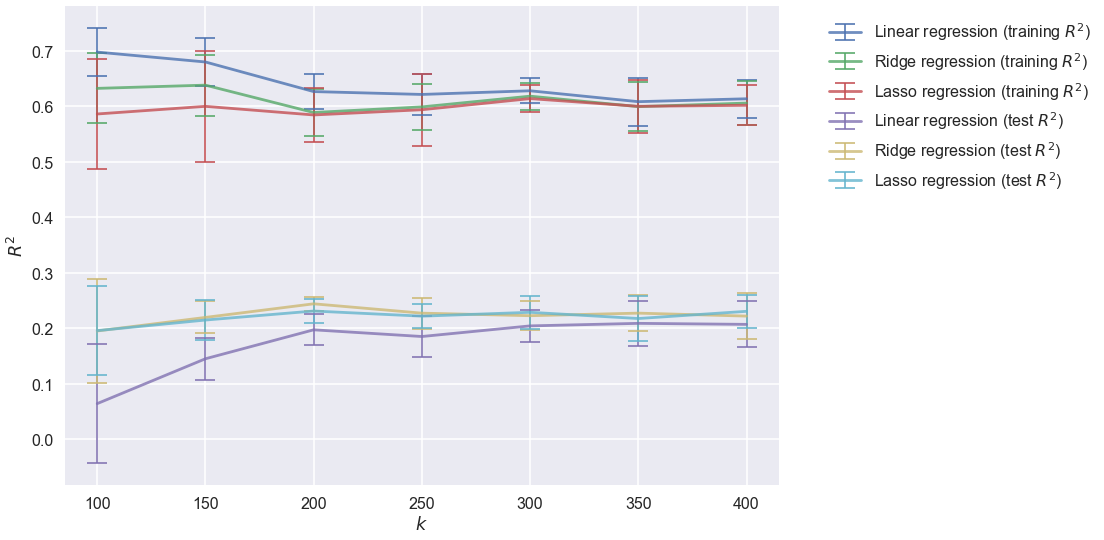

In [13]:
r2_mean = np.array([result.mean(axis=0) for result in results])
r2_std = np.array([result.std(axis=0) for result in results])
labels = ['Linear regression (training $R^2$)', 'Linear regression (test $R^2$)', \
         'Ridge regression (training $R^2$)', 'Ridge regression (test $R^2$)', \
         'Lasso regression (training $R^2$)', 'Lasso regression (test $R^2$)']
for i in [0, 2, 4, 1, 3, 5]:
    plt.errorbar(k_list, r2_mean[:, i], alpha=0.8, yerr=r2_std[:, i], capsize=10, elinewidth=2, markeredgewidth=2, \
                label=labels[i]);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);
plt.xlabel('$k$');
plt.ylabel('$R^2$');

In general, the training $R^2$ scores are similar for Ridge regression and Lasso regression, which are smaller than the training $R^2$ for linear regression; the test $R^2$ scores are smaller than the training $R^2$ scores; the test $R^2$ scores are similar for Ridge regression and Lasso regression, which are larger than the test $R^2$ for linear regression. The regularizaition terms are included in the loss functions of Ridge and Lasso regression, causing a smaller training $R^2$ (than linear regression without regularization). On the other hand, the regularization terms in Ridge and Lasso regression diminish the overfitting issue, resulting in a larger test $R^2$ (than linear regression without regularization).

The confidence intervals for the estimated $R^2$ decrease as training sample size increases.

Based on the plots, we would recommend Ridge or Lasso regression, of which the test $R^2$ scores are similar and higher, when we need to fit a regression model using a small training sample.

## Part (g): Polynomial & Interaction Terms

Moving beyond linear models, we will now try to improve the performance of the regression model in Part (b) from HW 3 by including higher-order polynomial and interaction terms. 

- For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a multiple regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in Part (b) from HW 3? Using a t-test, find out which of estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

- Fit a multiple linear regression model with additional interaction terms $\mathbb{I}_{month = 12} \times temp$ and $\mathbb{I}_{workingday = 1} \times \mathbb{I}_{weathersit = 1}$ and report the test $R^2$ for the fitted model. How does this compare with the $R^2$ obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?

In [14]:
# Additional polynomial terms

X_train = data_train.iloc[:, :-1].values
y_train = data_train.iloc[:, -1].values

X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

def add_poly_terms(X, inds, degree=4):
    for ind in inds:
        X = np.concatenate((X, np.array([X[:, ind]**i for i in range(2, degree+1)]).transpose()), axis=1)
    return X

def update_predictors(predictors, inds, degree=4):
    for ind in inds:
        predictors = predictors + [predictors[ind] + '^' + str(i) for i in range(2, degree+1)]
    return predictors

cp_inds = [all_predictors.index(p) for p in cp]
X_train_poly = add_poly_terms(X_train, cp_inds)
X_test_poly = add_poly_terms(X_test, cp_inds)
poly_predictors = update_predictors(all_predictors, cp_inds)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
X_train_poly = sm.add_constant(X_train_poly)
X_test_poly = sm.add_constant(X_test_poly)
poly_predictors = ['const'] + poly_predictors

result0 = sm.OLS(y_train, X_train).fit()
result = sm.OLS(y_train, X_train_poly).fit()
print('The test R^2 for linear regression model is {}.'.format(r2_score(y_test, result0.predict(X_test))))
print('The test R^2 for multiple regression model with additional polynomial terms is {}.'.\
     format(r2_score(y_test, result.predict(X_test_poly))))

The test R^2 for linear regression model is 0.24934211146527574.
The test R^2 for multiple regression model with additional polynomial terms is 0.27723843508615176.


The test $R^2$ of this model is higher than that of the linear model fitted in Part (b) from HW3.

In [15]:
# Check statistical significance

is_significant = result.pvalues < 0.05
sig_vars = [name for i, name in enumerate(poly_predictors) if is_significant[i]]
print('There are {} statistically significant coefficients (p < 0.05):'.format(len(sig_vars)))
print('\n'.join(['{}: value {}; standard error {}; p-value {}'.\
                format(name, result.params[is_significant][i], result.bse[is_significant][i], \
                       result.pvalues[is_significant][i])\
                for i, name in enumerate(sig_vars)]))

There are 6 statistically significant coefficients (p < 0.05):
const: value 5429.916277803321; standard error 711.1856189784676; p-value 3.262138038930577e-13
season_1.0: value -1523.2288234038806; standard error 467.58001308247367; p-value 0.0012562409900277584
weather_2.0: value 1103.011557374929; standard error 499.02336453814365; p-value 0.02785951161606185
humidity: value -668.9144631916308; standard error 157.3561955354788; p-value 2.8703429720927996e-05
windspeed: value -446.5085045541166; standard error 148.92909707051936; p-value 0.002950903968417459
temp^2: value -1811.0179723344477; standard error 816.9102468051536; p-value 0.02740199958574


In [16]:
poly_predictors

['const',
 'season_1.0',
 'season_2.0',
 'season_3.0',
 'month_1.0',
 'month_2.0',
 'month_3.0',
 'month_4.0',
 'month_5.0',
 'month_6.0',
 'month_7.0',
 'month_8.0',
 'month_9.0',
 'month_10.0',
 'month_11.0',
 'day_of_week_0.0',
 'day_of_week_1.0',
 'day_of_week_2.0',
 'day_of_week_3.0',
 'day_of_week_4.0',
 'day_of_week_5.0',
 'weather_1.0',
 'weather_2.0',
 'holiday',
 'workingday',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'temp^2',
 'temp^3',
 'temp^4',
 'atemp^2',
 'atemp^3',
 'atemp^4',
 'humidity^2',
 'humidity^3',
 'humidity^4',
 'windspeed^2',
 'windspeed^3',
 'windspeed^4']

In [17]:
# Additional interaction terms

X_train = data_train.iloc[:, :-1].values
y_train = data_train.iloc[:, -1].values

X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

inter_predictors = all_predictors + ['month_12.0Xtemp', 'workingday=1Xweather=1']
month_predictors = [p for p in all_predictors if 'month' in p]

def add_inter_terms(X, data):
    new_col = (1 - data[month_predictors].sum(axis=1).values) * data['temp'].values
    new_col = new_col.reshape((len(data), 1))
    X = np.concatenate((X, new_col), axis=1)
    new_col = data['weather_1.0'].values * data['workingday'].values
    new_col = new_col.reshape((len(data), 1))
    X = np.concatenate((X, new_col), axis=1)
    return X

X_train_inter = add_inter_terms(X_train, data_train)
X_test_inter = add_inter_terms(X_test, data_test)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
X_train_inter = sm.add_constant(X_train_inter)
X_test_inter = sm.add_constant(X_test_inter)
inter_predictors = ['const'] + inter_predictors

result0 = sm.OLS(y_train, X_train).fit()
result = sm.OLS(y_train, X_train_inter).fit()
print('The test R^2 for linear regression model is {}.'.format(r2_score(y_test, result0.predict(X_test))))
print('The test R^2 for multiple regression model with additional interaction terms is {}.'.\
     format(r2_score(y_test, result.predict(X_test_inter))))

The test R^2 for linear regression model is 0.24934211146527574.
The test R^2 for multiple regression model with additional interaction terms is 0.26851818962680996.


The test $R^2$ of this model is higher than that of the linear model fitted in Part (b) from HW3.

In [18]:
# Check statistical significance

is_significant = result.pvalues < 0.05
sig_vars = [name for i, name in enumerate(inter_predictors) if is_significant[i]]
print('There are {} statistically significant coefficients (p < 0.05):'.format(len(sig_vars)))
print('\n'.join(['{}: value {}; standard error {}; p-value {}'.\
                format(name, result.params[is_significant][i], result.bse[is_significant][i], \
                       result.pvalues[is_significant][i])\
                for i, name in enumerate(sig_vars)]))

There are 6 statistically significant coefficients (p < 0.05):
const: value 4734.015183791815; standard error 918.0107523681093; p-value 4.5612535012924353e-07
month_7.0: value -2140.04402367848; standard error 941.7748952367559; p-value 0.023770393363035575
weather_1.0: value 1339.914702308954; standard error 590.8030836647705; p-value 0.02404044509918082
weather_2.0: value 1563.2213099445257; standard error 477.69970906371077; p-value 0.0011904824828959742
humidity: value -574.1179358240837; standard error 113.992273826975; p-value 8.186394402382593e-07
windspeed: value -275.7456778883614; standard error 81.73658099192726; p-value 0.000839080259268073


The estimated coefficients for the interaction terms are not statistically significant at a significance level of 5%.

## Part (h): PCA to deal with high dimensionality

We would like to fit a model to include all main effects, polynomial terms up to the $4^{th}$ order, and all interactions between all possible predictors and polynomial terms (not including the interactions between $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ as they would just create higher order polynomial terms).  

- Create an expanded training set including all the desired terms mentioned above.  What are the dimensions of this 'design matrix' of all the predictor variables?   What are the issues with attempting to fit a regression model using all of these predictors?

- Instead of using the usual approaches for model selection, let's instead use principal components analysis (PCA) to fit the model.  First, create the principal component vectors in python (consider: should you normalize first?).  Then fit 5 different regression models: (1) using just the first PCA vector, (2) using the first two PCA vectors, (3) using the first three PCA vectors, etc...  Briefly summarize how these models compare in the training set.

- Use the test set to decide which of the 5 models above is best to predict out of sample.  How does this model compare to the previous models you've fit?  What are the interpretations of this model's coefficients?

In [19]:
# Reload data and expand training set

X_train = data_train.iloc[:, :-1].values
y_train = data_train.iloc[:, -1].values

X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

X_train_hd = PolynomialFeatures(interaction_only=True, include_bias=False).fit_transform(X_train)
X_test_hd = PolynomialFeatures(interaction_only=True, include_bias=False).fit_transform(X_test)

def add_poly_terms(X, inds, degree=4):
    for ind in inds:
        X = np.concatenate((X, np.array([X[:, ind]**i for i in range(2, degree+1)]).transpose()), axis=1)
    return X

cp_inds = [all_predictors.index(p) for p in cp]
X_train_hd = add_poly_terms(X_train_hd, cp_inds)
X_test_hd = add_poly_terms(X_test_hd, cp_inds)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

print(X_train_hd.shape)

(331, 418)


THe dimension of this "design matrix" of all the predictor variables is $331\times 418$ (without the constant term; it would be $331\times 419$ with the constant term). The model would suffer from overfitting if we attempt to fit a regression model using all of these predictors since there too many features.

We should normalize data (by column) before applying PCA. Also, we are supposed to use the normalization factors obtain from the training set to "normalize" the test set.

In [20]:
norm_factors = np.sqrt(np.sum(X_train_hd*X_train_hd, axis=0))
norm_factors = np.array([f if f > 1e-10 else 1 for f in norm_factors])
X_train_hd_normed = X_train_hd / norm_factors
X_test_hd_normed = X_test_hd / norm_factors

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [22]:
pca = PCA().fit(X_train_hd_normed)
pcs_train = pca.fit_transform(X_train_hd_normed)
pcs_test = pca.fit_transform(X_test_hd_normed)

In [23]:
def pcs_regression(n, pcs_train=pcs_train, y_train=y_train, pcs_test=pcs_test, y_test=y_test):
    X_train = pcs_train[:, :n]
    X_test = pcs_test[:, :n]
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    result = sm.OLS(y_train, X_train).fit()
    r2_train = r2_score(y_train, result.predict(X_train))
    r2_test = r2_score(y_test, result.predict(X_test))
    return r2_train, r2_test

In [24]:
for i in range(1, 6):
    r2 = pcs_regression(i)
    print('Using the first {} PCA vector(s): training R^2 {}; test R^2 {}.'.format(i, r2[0], r2[1]))

Using the first 1 PCA vector(s): training R^2 0.34644901150219565; test R^2 0.19449863531912115.
Using the first 2 PCA vector(s): training R^2 0.34858219488823594; test R^2 0.18608318640226706.
Using the first 3 PCA vector(s): training R^2 0.3681812604591641; test R^2 0.1648907746180851.
Using the first 4 PCA vector(s): training R^2 0.38066886426280266; test R^2 0.14054504998627182.
Using the first 5 PCA vector(s): training R^2 0.3811335019633668; test R^2 0.13789837608556066.


The training $R^2$ score increases as the number of PCA vectors used increases.

According to the result of test set, the first model (using the first PCA vector) is the best to predict out of sample. This model is worse than the previous models I've fit (smaller $R^2$ score). The model's coefficients indicate how the response is related to the position of data points projected to the directions which maximize the variance.

## Part (i): Beyond Squared Error

We have seen in class that the multiple linear regression method optimizes the Mean Squared Error (MSE) on the training set. Consider the following alternate evaluation metric, referred to as the Root Mean Squared Logarthmic Error (RMSLE):

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n (log(y_i+1) - log(\hat{y}_i+1))^2}.
$$

The *lower* the RMSLE the *better* is the performance of a model. The RMSLE penalizes errors on smaller responses more heavily than errors on larger responses. For example, the RMSLE penalizes a prediction of $\hat{y} = 15$ for a true response of $y=10$ more heavily than a prediction of $\hat{y} = 105$ for a true response of $100$, though the difference in predicted and true responses are the same in both cases. 

This is a natural evaluation metric for bike share demand prediction, as in this application, it is more important that the prediction model is accurate on days where the demand is low (so that the few customers who arrive are served satisfactorily), compared to days on which the demand is high (when it is less damaging to lose out on some customers).

The following code computes the RMSLE for you:

In [25]:
#--------  rmsle
# A function for evaluating Root Mean Squared Logarithmic Error (RMSLE)
# of the linear regression model on a data set
# Input: 
#      y_test (n x 1 array of response variable vals in testing data)
#      y_pred (n x 1 array of response variable vals in testing data)
# Return: 
#      RMSLE (float) 

def rmsle(y, y_pred):     
    # Evaluate sqaured error, against target labels
    # rmsle = \sqrt(1/n \sum_i (log (y[i]+1) - log (y_pred[i]+1))^2)
    rmsle_ = np.sqrt(np.mean(np.square(np.log(y+1) - np.nan_to_num(np.log(y_pred+1)))))
    
    return rmsle_


Use the above code to compute the training and test RMSLE for the polynomial regression model you fit in Part (g). 

You are required to develop a strategy to fit a regression model by optimizing the RMSLE on the training set. Give a justification for your proposed approach. Does the model fitted using your approach yield lower train RMSLE than the model in Part (g)? How about the test RMSLE of the new model? 

**Note:** We do not require you to implement a new regression solver for RMSLE. Instead, we ask you to think about ways to use existing built-in functions to fit a model that performs well on RMSLE. Your regression model may use the same polynomial terms used in Part (g).

In [26]:
from scipy.optimize import fmin

In [27]:
def loss_rmsle(coeff, X=X_train_poly, y=y_train):
    return rmsle(y, np.dot(X, coeff))

In [28]:
# Additional polynomial terms

X_train = data_train.iloc[:, :-1].values
y_train = data_train.iloc[:, -1].values

X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

def add_poly_terms(X, inds, degree=4):
    for ind in inds:
        X = np.concatenate((X, np.array([X[:, ind]**i for i in range(2, degree+1)]).transpose()), axis=1)
    return X

def update_predictors(predictors, inds, degree=4):
    for ind in inds:
        predictors = predictors + [predictors[ind] + '^' + str(i) for i in range(2, degree+1)]
    return predictors

cp_inds = [all_predictors.index(p) for p in cp]
X_train_poly = add_poly_terms(X_train, cp_inds)
X_test_poly = add_poly_terms(X_test, cp_inds)
poly_predictors = update_predictors(all_predictors, cp_inds)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
X_train_poly = sm.add_constant(X_train_poly)
X_test_poly = sm.add_constant(X_test_poly)
poly_predictors = ['const'] + poly_predictors

result = sm.OLS(y_train, X_train_poly).fit()
coeff0 = result.params

print('The RMSLE on the training set for the polynomial regression model in Part (g) is {}.'.format(loss_rmsle(coeff0)))

The RMSLE on the training set for the polynomial regression model in Part (g) is 0.7214576597005674.


We replace $\hat{y}$ no more than -1 by 0 to ensure the calculation of RMSLE. The replacement makes sense since it is reasonable to set $\hat{y}$ to zero when the model generates negative $\hat{y}$, which doesn't have any physical meaning and is usually rare. For the corner cases when $-1<\hat{y}<0$, the model might be penalized heavily, which is also reasonable. 

We can use the downhill simplex algorithm to minimize RMSLE, which can be implemented by `scipy.optimize.fmin` function in python. We can use the coefficients from Part (g) as the initial guess.

In [33]:
# Minimize RMSLE

coeff1 = fmin(loss_rmsle, coeff0, maxiter=100000)

Optimization terminated successfully.
         Current function value: 0.293973
         Iterations: 79528
         Function evaluations: 92421


In [34]:
print('The RMSLE on the training set for the polynomial regression model in Part (g) is {}.'.format(loss_rmsle(coeff0)))
#print('The RMSLE on the training set for the new model is {}.'.format(loss_rmsle(coeff)))
print()
print('The RMSLE on the test set for the polynomial regression model in Part (g) is {}.'.\
      format(loss_rmsle(coeff0, X_test_poly, y_test)))
print('The RMSLE on the test set for the new model is {}.'.\
      format(loss_rmsle(coeff1, X_test_poly, y_test)))

The RMSLE on the training set for the polynomial regression model in Part (g) is 0.7214576597005674.

The RMSLE on the test set for the polynomial regression model in Part (g) is 0.857618314536147.
The RMSLE on the test set for the new model is 0.8517121433528848.


As we can see, the new model yield lower train RMSLE than the model in Part (g). And the test RMSLE of the new model is slightly lower.

## Part (j): Dealing with Erroneous Labels

Due to occasional system crashes, some of the bike counts reported in the data set have been recorded manually. These counts are not very unreliable and are prone to errors. It is known that roughly 5% of the labels in the training set are erroneous (i.e. can be arbitrarily different from the true counts), while all the labels in the test set were confirmed to be accurate. Unfortunately, the identities of the erroneous records in the training set are not available. Can this information about presence of 5% errors in the training set labels (without details about the specific identities of the erroneous rows) be used to improve the performance of the model in Part (g)? Note that we are interested in improving the $R^2$ performance of the model on the test set (not the training $R^2$ score). 

As a final task, we require you to come up with a strategy to fit a regression model, taking into account the errors in the training set labels. Explain the intuition behind your approach (we do not expect a detailed mathematical justification). Use your approach to fit a regression model on the training set, and compare its test $R^2$ with the model in Part (g).

**Note:** Again, we do not require you to implement a new regression solver for handling erroneous labels. It is sufficient that you to come up with an approach that uses existing built-in functions. Your regression model may use the same polynomial terms used in Part (g).

In [35]:
# Reload data
# Additional polynomial terms

X_train = data_train.iloc[:, :-1].values
y_train = data_train.iloc[:, -1].values

X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

def add_poly_terms(X, inds, degree=4):
    for ind in inds:
        X = np.concatenate((X, np.array([X[:, ind]**i for i in range(2, degree+1)]).transpose()), axis=1)
    return X

def update_predictors(predictors, inds, degree=4):
    for ind in inds:
        predictors = predictors + [predictors[ind] + '^' + str(i) for i in range(2, degree+1)]
    return predictors

cp_inds = [all_predictors.index(p) for p in cp]
X_train_poly = add_poly_terms(X_train, cp_inds)
X_test_poly = add_poly_terms(X_test, cp_inds)
poly_predictors = update_predictors(all_predictors, cp_inds)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
X_train_poly = sm.add_constant(X_train_poly)
X_test_poly = sm.add_constant(X_test_poly)
poly_predictors = ['const'] + poly_predictors

result = sm.OLS(y_train, X_train_poly).fit()
coeff0 = result.params

We assume the erroneous records usually deviate more from its predicted value (generated by the correct model) than the correct records , and can thus approximate the identities of the erroneous records by those with top 5% highest standard error. Instead of minimizing RMSLE, we minimize a modified RMSLE which excludes data points with top 5% highest standard error (we calculate the absolute residues to find the data points to be excluded). Again, we can use numerical method (`scipy.optimize.fmin`) to minimize the modified RMSLE.

In [36]:
def rmsle_mod(y, y_pred, thres=0.05):    
    '''Returen RMSLE of the dataset excluding thres*100% data points with largest absolute residues'''
    r_abs = np.abs(y - y_pred)
    keep_ind = r_abs.argsort()[:int(len(r_abs)*(1-thres))]
    rmsle_ = np.sqrt(np.mean(np.square(np.log(y[keep_ind]+1) - np.nan_to_num(np.log(y_pred[keep_ind]+1)))))
    
    return rmsle_

def loss_rmsle_mod(coeff, X=X_train_poly, y=y_train, thres=0.05):
    return rmsle_mod(y, np.dot(X, coeff), thres)


In [37]:
coeff2 = fmin(loss_rmsle_mod, coeff0, maxiter=100000)

Optimization terminated successfully.
         Current function value: 0.253878
         Iterations: 33503
         Function evaluations: 40357


In [38]:
print('The RMSLE on the test set for the polynomial regression model in Part (g) is {}.'.\
      format(loss_rmsle(coeff0, X_test_poly, y_test)))
print('The RMSLE on the test set for the polynomial regression model in Part (i) is {}.'.\
      format(loss_rmsle(coeff1, X_test_poly, y_test)))
print('The RMSLE on the test set for the polynomial regression model in this part is {}.'.\
      format(loss_rmsle(coeff2, X_test_poly, y_test)))
print()
print('The R^2 score on the test set for the polynomial regression model in Part (g) is {}.'.\
      format(r2_score(y_test, np.dot(X_test_poly, coeff0))))
print('The R^2 score on the test set for the polynomial regression model in Part (i) is {}.'.\
      format(r2_score(y_test, np.dot(X_test_poly, coeff1))))
print('The R^2 score on the test set for the polynomial regression model in this part is {}.'.\
      format(r2_score(y_test, np.dot(X_test_poly, coeff2))))

The RMSLE on the test set for the polynomial regression model in Part (g) is 0.857618314536147.
The RMSLE on the test set for the polynomial regression model in Part (i) is 0.8517121433528848.
The RMSLE on the test set for the polynomial regression model in this part is 0.7936239647423046.

The R^2 score on the test set for the polynomial regression model in Part (g) is 0.27723843508615176.
The R^2 score on the test set for the polynomial regression model in Part (i) is 0.1785558555325888.
The R^2 score on the test set for the polynomial regression model in this part is 0.2800779317306492.


As we can see, the RMSLE for the model excluding training data points with top 5% highest standard error is smaller than the polynomial regression model in Part (g) and (i); the $R^2$ score is higher than the model in Part (g) and (i), indicating the perfomance is better for the model using this strategy.

---
--_

# APCOMP209a - Homework Question



##  Question 1: Student's t MLE

Use Maximum Likelihood Estimation to generate a linear regression model on the data provided in ``beerdata.csv`` considering two statistical models for noise: a) iid Normal and b) iid Student's t-distribution with $\nu=5$ and scale factor σ=0.5.  

Compare the two models performances and comment why it is perhaps appropriate to use the Student's t-distribution instead of the Normal? 





HINTS:
1. Use the probability density function for the Student's t distribution  with location μ and scale factor σ.
2. If the MLE regressions coefficients can not be derived analytically consider numerical methods.
3. You can use sklearn or statsmodel for the Normal case 




## Question 2 (continued from HW2) 

Read sections 1 and 2 of this [paper](https://www.researchgate.net/profile/Roberto_Togneri/publication/45094554_Linear_Regression_for_Face_Recognition/links/09e4150d243bd8b987000000/Linear-Regression-for-Face-Recognition.pdf). 

Briefly, the model leverages the concept that "patterns from a single-object class lie on a linear subspace."   It also makes use of the idea of linear regression as a problem about projections.  In this case, given a vector $y$, the goal is to find the subspace induced by $\mathrm{Col} \, \mathbf X$ that produced the 'closest' projection vector $\widehat y$ to the original $y$.  

### Question 2a

As discussed in the paper, our face dataset contains cleaned images of faces belonging to different people. Assuming that patterns (faces) from one class (person) are elements of the same subspace, let's try to classify an unknown face using the method presented in the paper.  For each class $i$, we need to:

1. construct the $\mathbf H_i$ hat matrix from known faces, being careful to follow the column concatenation step described in the paper to convert an image into its vector representation;
2. calculate the predicted $\widehat y_i$, the closest vector in $\mathrm{Col} \, \mathbf X_i$ to $y$; and
3. calculate the magnitude of the difference vector between $y$ and $\widehat y_i$.

You should then be able to make a classification decision.

**Notes:**
- Use the provided code to download and re-sample the dataset.
- Follow the normalisation step in the paper to ensure the "maximum pixel value is 1".
- Your classifier should have approximately an 80% accuracy.
- Use the image plotting library of matplotlib to display one (or two) correctly classified faces and the known faces.
- Use the image plotting library of matplotlib to display one (or two) incorrectly classified faces and the known faces.
    
### Question 2b - Significant Faces
Select an example of a correctly classified face. Use statsmodels to investigate the most predictive columns (faces) that the model used in this regression:

(i) Which columns (i.e. faces) make the highest contribution to the projection?

(ii) Which columns (i.e. faces) are the least useful in making this projection?

Plot the correctly assigned face, and the two faces from the questions (i) and (ii). What do you notice about these faces?

In [ ]:
from io import BytesIO
from zipfile import ZipFile
import urllib
import os

# Note that you may need to run the following command to install Python Image Library (PIL)
#pip install Pillow
from PIL import Image
import numpy as np
from sklearn.cross_validation import train_test_split

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# starter functions provided to students
def rgb2gray(rgb):
    '''
    function to convert RGB image to gray scale
    accepts 3D numpy array and returns 2D array with same dimensions
    as the first two dimensions of input
    '''
    
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def fetch_and_read_data(shape=(50,30)):
    
    '''
    Function to download image data, store in a local folder (note this is 18.4mb), only download the data when
    the local folder is not present, read in the images, downsample them to the specified shape (default = (50x30) (rows x cols))
    and finally split them into a four tuple return object.
    
    Returns:
        - 1) training image data (i.e. images that should form the predictor matrix in your solution)
        - 2) training image data labels (i.e. labels from 1 to 50 that identify which face (1) belongs to)
        - 3) testing image data (i.e. data that you should use to try and classify - note this forms the predictor variable in your regression)
        - 4) testing image data labels (i.e. the labels for (3) - this is to allow you to evaluate your model)
    
    ___________________
    Aside:
    If you want to change the sampling dimensions of your data, pass the shape = (x,y) argument to the method where
    y is the number of columns and x is the number of rows in the image.
    '''
    
    if not os.path.exists('./cropped_faces'):
        url = urllib.request.urlopen("http://www.anefian.com/research/GTdb_crop.zip")
        
        zipfile = ZipFile(BytesIO(url.read()))
        zipfile.extractall()
     
    data = []
    labels = []
    
    files = os.listdir('cropped_faces')
    for f in files:
        if '.jpg' in f:
            image = Image.open('cropped_faces/' + f)
            image = image.resize((shape[1], shape[0]))
            data.append(rgb2gray(np.asarray(image)))
            labels.append(int(f.split('_')[0][1:]) - 1)
            
    data = np.array(data)
    
    trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, stratify=labels)
    return np.array(trainX), np.array(testX), np.array(trainY), np.array(testY)

In [ ]:
# starter code for the students
train_dataset, test_dataset, train_labels, test_labels = fetch_and_read_data()

# code to plot some of the images
fig, axes = plt.subplots(2,4,figsize=(10,5))
axes = axes.flatten()
[axes[i].imshow(train_dataset[i], cmap='gray') for i in range(len(axes))]
plt.show()